# Chapter 11, Part 2 - Bayesian Causal Graphical Inference Workflow
The notebook is a code companion to chapter 11 of the book [Causal AI](https://www.manning.com/books/causal-ai) by [Robert Osazuwa Ness](https://www.linkedin.com/in/osazuwa/).  View the [book resources](https://www.altdeep.ai/causalaibook) to see other tutorials and book-related links.
<a href="https://colab.research.google.com/github/altdeep/causalML/blob/master/book/chapter%2011/Chapter_11_Bayesian_Causal_Graphical_Inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyro-ppl==1.9
!pip install graphviz==0.20
!pip install pandas==1.5.3
!pip install torch==2.2.1+cu121

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 745.2/745.2 kB 1.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In this chapter, we use Bayesian inference on a causal generative model defined a Pyro to estimate a causal effect. There is a latent confounder and the causal effect is identified through the front-door. We use stochastic variational inference to infer the posterior on the latent confounder and parameters, then simulate intervention data using Pyro's do-operator from the posterior predictive distribution. These samples are used to estimate the average treatment effect.

We target the following DAG, where the grey variables are latent.

![online gaming dag with latents](https://github.com/altdeep/causalML/blob/master/book/chapter%2011/images/latentDAG.png?raw=true)

We train the following model where Z is a proxy for the latent confounding in the DAG.

![online gaming dag with latent Z](https://github.com/altdeep/causalML/blob/master/book/chapter%2011/images/latentDAGsub.png?raw=true).

## Listing 11.20 Load and reduce data to a subset of observed variables

Our model will have two decoders. One “decoder” maps Z and G to E, returning a derived parameter ρ_engagement that act as the probability that side quest engagement is high. Let’s call this network Confounders2Engagement.

In [ ]:
import pandas as pd
import torch

url = ("https://raw.githubusercontent.com/altdeep/"    #A
       "causalML/master/datasets/online_game_ate.csv")    #A
df = pd.read_csv(url)    #A
df = df[["Guild Membership", "Side-quest Engagement",   #B
         "Won Items", "In-game Purchases"]]   #B

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")    #C
data = {    #C
    col: torch.tensor(df[col].values, dtype=torch.float32).to(device)    #C
    for col in df.columns    #C
}    #C
#A Load the data.
#B Drop everything but Guild Membership, Side-quest Engagement, Won Items, In-game Purchases.
#C Convert the data to tensors and dynamically set the device for performing tensor computations depending on the availability of a CUDA-enabled GPU.

## Listing 11.21 Specify Confounders2Engagement neural network

Our model will have two decoders. One “decoder” maps Z and G to E, returning a derived parameter ρ_engagement that act as the probability that side quest engagement is high. Let’s call this network Confounders2Engagement.

In [ ]:
import torch.nn as nn

class Confounders2Engagement(nn.Module):
    def __init__(
        self,
        input_dim=1+1,    #A
        hidden_dim=5    #B
    ):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)   #C
        self.f_engagement_ρ = nn.Linear(hidden_dim, 1)    #D
        self.softplus = nn.Softplus()    #E
        self.sigmoid = nn.Sigmoid()    #F

    def forward(self, input):
        input = input.t()
        hidden = self.softplus(self.fc1(input))    #G
        ρ_engagement = self.sigmoid(self.f_engagement_ρ(hidden))    #H
        ρ_engagement = ρ_engagement.t().squeeze(0)
        return ρ_engagement
#A Input is confounder proxy Z concatenated with Guild Membership.
#B Choosing a hidden dimension of width 5.
#C Linear map from input to hidden dimension.
#D Linear map from hidden dimension to In-Game Purchases location parameter.
#E Activation function for hidden layer.
#F Activation function for Side-quest engagement parameter.
#G From input to hidden layer
#H From hidden layer to ρ_engagement

## Listing 11.22 Specify PurchasesNetwork neural network

Next, let’s specify another neural net decoder that maps Z, W, and G to a location and scale parameter for I. Let’s call this PurchasesNetwork.

In [ ]:
class PurchasesNetwork(nn.Module):
    def __init__(
        self,
        input_dim=1+1+1,    #A
        hidden_dim=5    #B
    ):
        super().__init__()
        self.f_hidden = nn.Linear(input_dim, hidden_dim)   #C
        self.f_purchase_μ = nn.Linear(hidden_dim, 1)    #D
        self.f_purchase_σ = nn.Linear(hidden_dim, 1)    #E
        self.softplus = nn.Softplus()    #F

    def forward(self, input):
        input = input.t()
        hidden = self.softplus(self.f_hidden(input))    #G
        μ_purchases = self.f_purchase_μ(hidden)   #H
        σ_purchases = 1e-6 + self.softplus(self.f_purchase_σ(hidden))    #I
        μ_purchases = μ_purchases.t().squeeze(0)
        σ_purchases = σ_purchases.t().squeeze(0)
        return μ_purchases, σ_purchases
#A Input is confounder proxy Z concatenated with Guild Membership and Won Items.
#B Choosing a hidden dimension of width 5.
#C Linear map from input to hidden dimension.
#D Linear map from hidden dimension to In-Game Purchases location parameter.
#E Linear map from hidden dimension to In-Game Purchases location parameter.
#F Activation for hidden layer.
#G From input to hidden layer.
#H Mapping from hidden layer to location parameter for purchases.
#I Mapping from hidden layer scale parameter for purchases. The 1e-6 lets us avoid scale values of 0.

## Listing 11.23 Specify the causal model

Now we use both networks to specify the causal model. The model will take a dictionary of parameters called params and use them to sample the variables in the model.

In [ ]:
from pyro import sample
from pyro.distributions import Bernoulli, Normal
from torch import tensor, stack

def model(params, device=device):    #A
    z_dist = Normal(    #B
        tensor(0.0, device=device),    #B
        tensor(1.0, device=device))    #B
    z = sample("Z", z_dist)    #B
    member_dist = Bernoulli(params['ρ_member'])    #C
    is_guild_member = sample("Guild Membership", member_dist)    #C
    engagement_input = stack((is_guild_member, z)).to(device)   #D
    ρ_engagement = confounders_2_engagement(engagement_input)    #D
    engage_dist = Bernoulli(ρ_engagement)
    is_highly_engaged = sample("Side-quest Engagement", engage_dist)    #E
    p_won = (    #F
        params['ρ_won_engaged'] * is_highly_engaged +    #F
        params['ρ_won_not_engaged'] * (1 - is_highly_engaged)    #F
    )    #F
    won_items = sample("Won Items", Bernoulli(p_won))    #F
    purchase_input = stack((won_items, is_guild_member, z)).to(device)    #G
    μ_purchases, σ_purchases = purchases_network(purchase_input)    #G
    purchase_dist = Normal(μ_purchases, σ_purchases)    #H
    in_game_purchases = sample("In-game Purchases", purchase_dist)    #H
#A The causal model.
#B A latent variable that acts as a proxy for other confounders.
#C Whether someone is in a guild.
#D Use confounders_2_engagement map is_guild_member and z to a parameter for Side-quest Engagement and In-game Purchases.
#E Modeling Side-quest Engagement
#F Modeling amount of won items
#G Use confounders_2_purchases to map is_guild_member, z, and won-items to in_game_purchases.
#H Model in_game_purchases

## Listing 11.24 Build a data model

This model represents a single data point. Now we need to extend the model to every example data point in the dataset. We build a data_model that loads the neural networks, assigns priors to the parameters, and models the data.

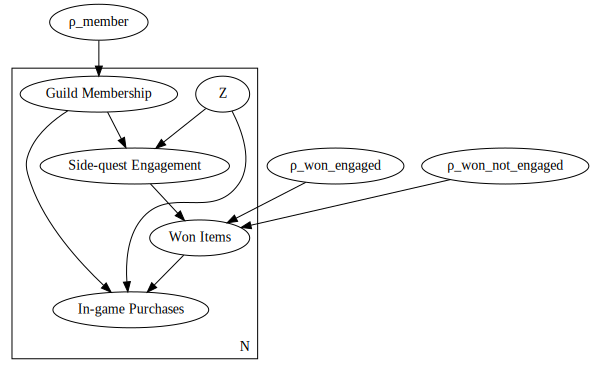

In [ ]:
import pyro
from pyro import render_model, plate
from pyro.distributions import Beta
from pyro import render_model

confounders_2_engagement = Confounders2Engagement().to(device)    #A
purchases_network = PurchasesNetwork().to(device)    #A
def data_model(data, device=device):
    pyro.module("confounder_2_engagement", confounders_2_engagement)    #B
    pyro.module("confounder_2_purchases", purchases_network)    #B
    two = tensor(2., device=device)
    five = tensor(5., device=device)
    params = {
        'ρ_member': sample('ρ_member', Beta(five, five)),    #C
        'ρ_won_engaged': sample('ρ_won_engaged', Beta(five, two)),    #D
        'ρ_won_not_engaged': sample('ρ_won_not_engaged', Beta(two, five)),    #E
    }
    N = len(data["In-game Purchases"])
    with plate("N", N):    #F
        model(params)    #F

render_model(data_model, (data, ))
#A Initialize the neural networks
#B pyro.module lets Pyro know about all the parameters inside the networks
#C Sample from prior distribution for ρ_member
#E Sample prior distribution for ρ_won_not_engaged
#F The plate context manager declares N independent samples (observations) from the causal variables.

## Listing 11.25 Create encoder for Z

The main ingredient of the guide function is an encoder that will map Side-quest Engagement, Won Items, and In-game Purchases to Z, i.e., it will impute the latent values of Z.

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim=3, #A
                 z_dim=1,    #B
                 hidden_dim=5):    #C
        super().__init__()
        self.f_hidden = nn.Linear(input_dim, hidden_dim)
        self.f_loc = nn.Linear(hidden_dim, z_dim)
        self.f_scale = nn.Linear(hidden_dim, z_dim)
        self.softplus = nn.Softplus()

    def forward(self, input):
        input = input.t()
        hidden = self.softplus(self.f_hidden(input))    #D
        z_loc = self.f_loc(hidden)   #E
        z_scale = 1e-6 + self.softplus(self.f_scale(hidden))    #F
        return z_loc.t().squeeze(0), z_scale.t().squeeze(0)
#A Input dimension is 3 because it will combine Side-quest Engagement, In-Game Purchases, and Guild Membership.
#B I use a simple univarite Z, but one could give it higher dimension with sufficient data.
#C The width of the hidden layer is 5.
#D Go from input to hidden layer.
#E Mapping from hidden layer to location parameter for Z.
#F Mapping from hidden layer scale parameter to Z.

## Listing 11.26 Build the guide function (approximating distribution)

We have a data model over an underlying causal model. We now move onto inference. Using SVI, we need to build a guide function that represents a distribution that approximates the posterior – the guide function will have hyperparameters directly optimized during training, which will bring the approximating distribution as close as possible to the posterior.

In [ ]:
from pyro import param
from torch.distributions.constraints import positive

encoder = Encoder().to(device)

def guide(data, device=device):
    pyro.module("encoder", encoder)
    α_member = param("α_member", tensor(1.0, device=device),    #A
                     constraint=positive)    #A
    β_member = param("β_member", tensor(1.0, device=device),    #A
                        constraint=positive)    #A
    sample('ρ_member', Beta(α_member, β_member))    #A
    α_won_engaged = param("α_won_engaged", tensor(5.0, device=device),    #B
                         constraint=positive)    #B
    β_won_engaged = param("β_won_engaged", tensor(2.0, device=device),    #B
                        constraint=positive)    #B
    sample('ρ_won_engaged', Beta(α_won_engaged, β_won_engaged))    #B
    α_won_not_engaged = param("α_won_not_engaged",    #B
                        tensor(2.0, device=device),    #B
                        constraint=positive)    #B
    β_won_not_engaged = param("β_won_not_engaged",    #B
                        tensor(5.0, device=device),    #B
                        constraint=positive)    #B
    beta_dist = Beta(α_won_not_engaged, β_won_not_engaged)    #B
    sample('ρ_won_not_engaged', beta_dist)    #B
    N = len(data["In-game Purchases"])
    with pyro.plate("N", N):
        z_input = torch.stack(    #C
            (data["Guild Membership"],    #C
             data["Side-quest Engagement"],    #C
             data["In-game Purchases"])    #C
        ).to(device)    #C
        z_loc, z_scale = encoder(z_input)    #C
        pyro.sample("Z", Normal(z_loc, z_scale))    #C
#A The guide samples ρ_member from a Beta distribution where the shape parameters are trainable.
#B ρ_won_engaged and p_won_not_engaged are also sampled from Beta distributions with trainable parameters.
#C Z is sampled from a Normal with parameters returned by the encoder.


## Listing 11.27 Run the training loop

Finally, we setup the inference algorithm and run the training loop.

In [ ]:
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from pyro import condition

pyro.clear_param_store()    #A
adam_params = {"lr": 0.0001, "betas": (0.90, 0.999)}    #B
optimizer = Adam(adam_params)    #B
training_model = condition(data_model, data)    #C
svi = SVI(training_model, guide, optimizer, loss=Trace_ELBO())    #D
elbo_values = []    #E
N = len(data['In-game Purchases'])    #E
for step in range(500_000):    #E
    loss = svi.step(data) / N    #E
    elbo_values.append(loss)   #E
    if step % 500 == 0:    #E
        print(loss)    #E
#A Erase parameter values in case you restart the training loop.
#B Setup Adam optimizer. A learning rate ("lr") of 0.001 may work better if using CUDA.
#C Condition the data_model on the observed data
#D Setup SVI.
#E Run the training loop.

9376.785272843455
7397.673315441324
5814.800609522961
4700.470196167558
3952.7410289988698
3397.5977610998325
2963.1361438773706
2602.9678564968744
2191.8126980765874
1802.0721578897073
1535.7837295118093
1339.2009410804153
1186.2892710766732
1057.2279397213056
948.448569644545
855.4255571918696
772.1538882181912
699.5327743845195
635.6652349130541
579.4282243771494
527.5148253724501
481.8920025137603
442.2274184648335
405.9887741065085
373.58388065642714
345.0672399093539
319.784513239485
296.41576834359466
275.25930396348537
256.51504616796075
240.9036919308305
224.1851144174546
209.94536831279396
196.93325250093937
186.42896900570392
173.89639909532517
164.29400935875177
154.4155576823771
145.72739035046698
137.6741947968483
130.5024443918973
123.29393645623028
118.12267169065476
111.26747908831835
105.80506859676093
100.34016217760146
95.73261912064552
91.03480313991905
86.99859012112617
83.60036580612064
79.3694331625998
75.98481556489318
72.71398993841112
69.66921446465552
67.354

## Listing 11.28 Plot the losses during training

We plot the loss curve to see how training performed.

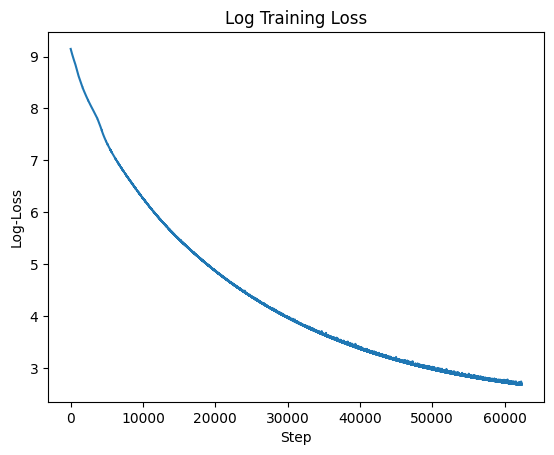

In [ ]:
import math
import matplotlib.pyplot as plt

plt.plot([math.log(item) for item in elbo_values])    #A
plt.xlabel('Step')    #A
plt.ylabel('Log-Loss')    #A
plt.title('Log Training Loss')    #A
plt.show()    #A
#A Plot the log of training loss since loss is initially large.


## Listing 11.29 Print the values of the trained parameters in the guide function

We can print the trained values of the hyperparameters (α_member, β_member, α_won_engaged, β_won_engaged, α_won_not_engaged, and β_won_not_engaged).

In [ ]:
print((    #A
     pyro.param("α_member"),    #A
     pyro.param("β_member"),    #A
     pyro.param("α_won_engaged"),    #A
     pyro.param("β_won_engaged"),    #A
     pyro.param("α_won_not_engaged"),    #A
     pyro.param("β_won_not_engaged")    #A
))    #A
#A Print the hyperparameter values learned during training.

(tensor(3.8327, grad_fn=<AddBackward0>), tensor(3.7398, grad_fn=<AddBackward0>), tensor(9.2200, grad_fn=<AddBackward0>), tensor(6.4267, grad_fn=<AddBackward0>), tensor(0.3379, grad_fn=<AddBackward0>), tensor(73.0602, grad_fn=<AddBackward0>))


## Listing 11.30 Posterior predictive check of In-game Purchases

Given a sample of the parameters and a sample vector of Z from the guide (our proxy for the posterior), we can simulate a new data set. A common way of checking how well a Bayesian model fits the data is to compare this simulated data with the original data. This comparison is called a posterior predictive check, and it helps us understand if the trained model is a good fit for the data. In the following code, I do a posterior predictive check of In-Game Purchases; I use the guide to generate samples and use those samples to repeatedly simulate In-Game Purchase datasets. For each simulated dataset I create a density curve. I plot these curves, along with the density curve of the In-Game Purchases in the original data.

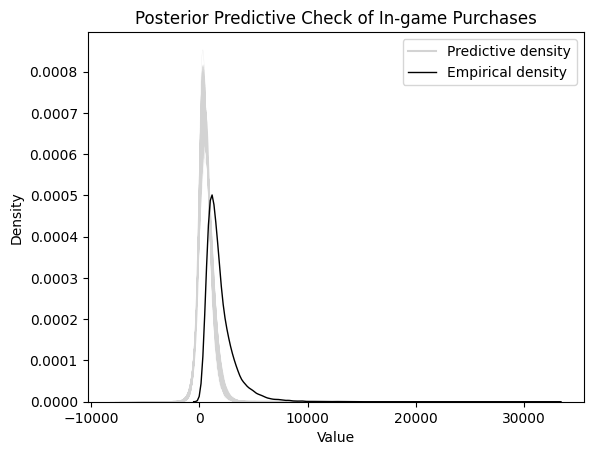

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyro.infer import Predictive

predictive = Predictive(data_model, guide=guide, num_samples=1000)    #A
predictive_samples_all = predictive(data)    #A
predictive_samples = predictive_samples_all["In-game Purchases"]    #A
for i, sample_data in enumerate(predictive_samples):    #B
    if i == 0:    #B
        sns.kdeplot(sample_data,    #B
            color="lightgrey", label="Predictive density")    #B
    else:    #B
        sns.kdeplot(sample_data,    #B
            color="lightgrey", linewidth=0.2, alpha=0.5)    #B

sns.kdeplot(    #C
    data['In-game Purchases'],    #C
    color="black",    #C
    linewidth=1,    #C
    label="Empirical density"    #C
)    #C

plt.legend()
plt.title("Posterior Predictive Check of In-game Purchases")
plt.xlabel("Value")
plt.ylabel("Density")
plt.show()
#A Simulate data from the (approximate) posterior predictive distribution.
#B For each batch of simulated data, create and plot a density curve of in-game purchases.
#C Overlay the empirical density distribution of in-game purchases so we can compare with the predictive plots.


## Listing 11.31 Sampling from the posterior predictive distributions $P(I_{E=0})$ & $P(I_{E=1})$.

Our Bayesian estimator of the ATE will be our approach of applying transformation and inference to the posterior distribution represented by our model and guide. Since the ATE is $E(I_{E=1}) - E(I_{E=0})$ we’ll do posterior predictive sampling from $P(I_{E=1})$ and $P(I_{E=0})$. First, we use pyro.do to transform the model to represent the intervention. Then we’ll do forward sampling from the model using the Predictive class. This will sample 1000 datasets, each equal in length to the original data, and each corresponding a random sample of the ρ_member, ρ_won_engaged, ρ_won_unengaged and a vector of Z values. Objects from the Predictive class do simple forward sampling.  If we needed to condition on anything (e.g., conditioning on E=1 in $P(I_{E=0}|E=1))$, we’d would need use another inference approach (e.g., importance sampling, MCMC, etc.).

In [ ]:
from pyro.infer import Predictive
from pyro import do

data_model_low_engagement = do(    #A
    data_model, {"Side-quest Engagement": 0.})    #A
predictive_low_engagement = Predictive(    #B
    data_model_low_engagement, guide=guide, num_samples=1000)    #B
predictive_low_engagement_samples = predictive_low_engagement(data)    #B

data_model_high_engagement = do(    #C
    data_model, {"Side-quest Engagement": 1.})    #C
predictive_high_engagement = Predictive(    #D
    data_model_high_engagement, guide=guide, num_samples=1000)    #D
predictive_high_engagement_samples = predictive_high_engagement(data)    #D
#A Apply pyro.do transformation to implement intervention do(E=0)
#B Sample 1000 samples of datasets from P(IE=0)
#C Apply pyro.do transformation to implement intervention do(E=1)
#D Sample 1000 samples of datasets from P(IE=1)

## Listing 11.32 Plot density curves of predictive datasets sampled from $P(I_{E=1})$ & $P(I_{E=0})$

We can plot these two sets of posterior predictive samples as follows:

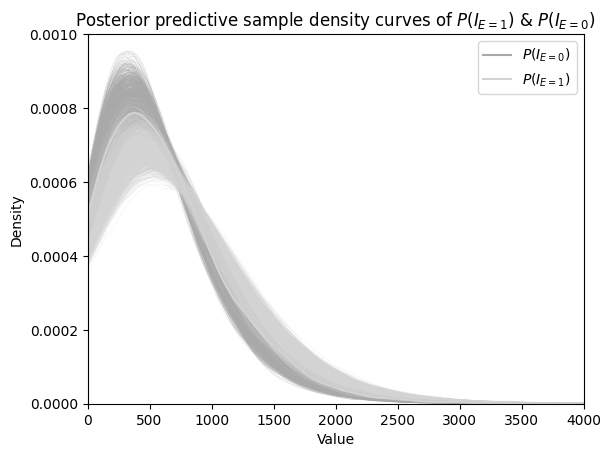

In [ ]:
low_samples = predictive_low_engagement_samples["In-game Purchases"]    #A
for i, sample_data in enumerate(low_samples):    #A
    if i == 0:    #A
        sns.kdeplot(sample_data,    #A
            clip=(0, 35000), color="darkgrey", label="$P(I_{E=0})$")    #A
    else:    #A
        sns.kdeplot(sample_data,    #A
            clip=(0, 35000), color="darkgrey",    #A
            linewidth=0.2, alpha=0.5)    #A

high_samples = predictive_high_engagement_samples["In-game Purchases"]    #A
for i, sample_data in enumerate(high_samples):    #A
    if i == 0:    #A
        sns.kdeplot(sample_data,    #A
            clip=(0, 35000), color="lightgrey", label="$P(I_{E=1})$")    #A
    else:    #A
        sns.kdeplot(sample_data,    #A
            clip=(0, 35000), color="lightgrey",
            linewidth=0.2, alpha=0.5)    #A
title = ("Posterior predictive sample density "    #B
         "curves of $P(I_{E=1})$ & $P(I_{E=0})$")    #B
plt.title(title)    #B
plt.legend()    #B
plt.xlabel("Value")    #B
plt.ylabel("Density")    #B
plt.ylim((0, .0010))    #B
plt.xlim((0, 4000))    #B
plt.show()    #B
#A For each sample, use kdeplot to draw a curve. Plot P(IE=0) as dark grey and P(IE=1) as light grey.
#B Plot the density curves.

## Listing 11.33 Estimate the ATE

Finally, to estimate $E(I_{E=1})$ and $E(I_{E=0})$, we just need take the means of each posterior predictive sample dataset simulated from $P(I_{E=1})$ and $P(I_{E=1})$, respectively. This will yield 1000 samples of posterior predictive values of the ATE. Variation between the samples reflects posterior uncertainty about the ATE.

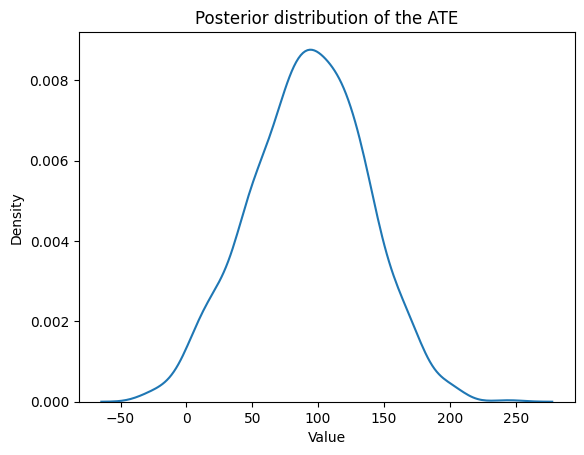

In [ ]:
samp_high = predictive_high_engagement_samples['In-game Purchases']    #A
exp_high = samp_high.mean(1)    #A
samp_low = predictive_low_engagement_samples['In-game Purchases']    #B
exp_low = samp_low.mean(1)    #B
ate_distribution = exp_high - exp_low    #C

sns.kdeplot(ate_distribution)    #D
plt.title("Posterior distribution of the ATE")    #D
plt.xlabel("Value")    #D
plt.ylabel("Density")    #D
plt.show()    #D
#A Estimate E(IE=1)
#B Estimate E(IE=0)
#C Estimate the ATE = E(IE=1) - E(IE=0)
#D Use a density curve to visualize posterior variation in the ATE values.